<img src="https://imagedelivery.net/Dr98IMl5gQ9tPkFM5JRcng/3e5f6fbd-9bc6-4aa1-368e-e8bb1d6ca100/Ultra" alt="Image description" width="160" />

<br/>

# Introduction to Contextual AI Platform using the Python Client

Contextual AI lets you create and use generative AI agents. This notebook introduces an end-to-end example workflow for creating a Retrieval-Augmented Generation (RAG) agent for a financial use case. The agent will answer questions based on the documents provided, but avoid any forward looking statements, e.g., Tell me about sales in 2028. This notebook uses the python client.

This notebook covers the following steps:
- Creating a Datastore
- Ingesting Documents
- Creating an RAG Agent
- Querying an RAG Agent
- Evaluating an RAG Agent
- Improving the RAG Agent (Updating prompt and tuning)

With the exception of the tuning model, the rest of the notebook can be run in under 15 minutes. The full documentation is available at [docs.contextual.ai](https://docs.contextual.ai/)

To run this notebook interactively, you can open it in Google Colab. However, make sure to copy over the additional files.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ContextualAI/examples/blob/main/01-getting-started/end-to-end-example.ipynb)

In [141]:
%pip install contextual-client matplotlib tqdm requests

In [142]:
import os
import json
import requests
from pathlib import Path
from typing import List, Optional, Dict
from IPython.display import display, JSON
import pandas as pd
from contextual import ContextualAI
import ast

In [143]:
#Setup API key
#os.environ["CONTEXTUAL_API_KEY"] = API_KEY  # You can store the API key is stored as the environment variable

client = ContextualAI(
    api_key=os.environ.get("CONTEXTUAL_API_KEY"),  # This is the default and can be omitted
)

## Step 1: Create your Datastore


You will need to first create a datastore for your agent using the  /datastores endpoint. A datastore is secure storage for data. Each agent will have it's own datastore for storing data securely.

In [144]:
# Check if datastore exists
datastores = client.datastores.list()
existing_datastore = next((ds for ds in datastores if ds.name == "Demo_fin_rag"), None)

if existing_datastore:
    datastore_id = existing_datastore.id
    print(f"Using existing datastore with ID: {datastore_id}")
else:
    result = client.datastores.create(name="Demo_fin_rag")
    datastore_id = result.id
    print(f"Created new datastore with ID: {datastore_id}")

Using existing datastore with ID: 54f324d5-3142-4449-a08c-8b99a80cb315


## Step 2: Ingest Documents into your Datastore

You can now ingest documents into your Agent's datastore using the /datastores endpoint. Documents must be a PDF or HTML file.


I am using a example PDF. You can also use your own documents here. If you have very long documents (hundreds of pages), processing can take longer.

In [145]:
if not os.path.exists('data'):
    os.makedirs('data')

if not os.path.exists('data/CDA 4205 Computer Architecture Exam 2 Practice Solution-2.pdf'):
    print(f"Fetching data/CDA 4205 Computer Architecture Exam 2 Practice Solution-2.pdf")
    response = requests.get("data/CDA 4205 Computer Architecture Exam 2 Practice Solution-2.pdf")
    with open('data/CDA 4205 Computer Architecture Exam 2 Practice Solution-2.pdf', 'wb') as f:
        f.write(response.content)

Let's ingest the file

In [146]:
with open('data/CDA 4205 Computer Architecture Exam 2 Practice Solution-2.pdf', 'rb') as f:
    ingestion_result = client.datastores.documents.ingest(datastore_id, file=f)
    document_id = ingestion_result.id
    print(f"Successfully uploaded to datastore {datastore_id}")

Successfully uploaded to datastore 54f324d5-3142-4449-a08c-8b99a80cb315


Once ingested, you can view the list of documents, see their metadata, and also delete documents.

In [147]:
metadata = client.datastores.documents.metadata(datastore_id = datastore_id, document_id = document_id)
print("Document metadata:", metadata)

Document metadata: DocumentMetadata(id='5444a323-1369-4db9-b9ae-fb1e2aa67627', created_at='2025-05-27T18:08:40.293747', name='CDA 4205 Computer Architecture Exam 2 Practice Solution-2.pdf', status='pending', custom_metadata={}, updated_at=None)


## Step 3: Create your Agent

Next let's create the Agent and modify it to our needs.


Some additional parameters include setting a system prompt or using a previously tuned model.

`system_prompt` is used for the instructions that your RAG system references when generating responses. Note that we do not guarantee that the system will follow these instructions exactly.

`llm_model_id` is the optional model ID of a tuned model to use for generation. Contextual AI will use a default model if none is specified.

In [148]:
system_prompt = '''
You are a language model assisting with the digitization of academic exam content. The input is an exam which has been parsed into Markdown text. The exam contains one or more problems from a Computer Architecture assessment. A problem may include any combination of the following:
A context paragraph and/or just a short statement. (For example, it might be as short as "Convert the number 42 to binary," or as long as "Recall that the crux of tracing-based GC algorithms such as Mark-and-sweep
and Mark-sweep-compact is to start from “root”
variables and then identify all the reachable
variables. In the following code snippet, suppose the program just finishes executing L7, which
variables are regarded as “root”? Name only those that point to variables on the heap.
L1: int *p3;
L2: int* foo(int n) {
L3: int i,
*p1;
L4: p1 = (int *) malloc(n * sizeof(int));
L5: for (i=0; i<n; i++)
L6: p1[i] = i;
L7: p3 = p1[2];
L8: return p1;
L9: }
L10: void bar() {
L11: int *p2 = foo(5);
L12: }


")


One or more sub-questions, or be a single standalone question
Context for sub-questions separate from the sub-question and separate from the original problem context
Multiple questions within a subquestion
Point value associations for the problem or subproblems, including extra credit points
Solutions, either typed or handwritten
Tables, diagrams, circuit schematics, or block diagrams
Your task is to identify and separate each exam problem into the listed components, including context, sub-questions, figures, and solutions. Ignore any point values for any problem, question, or sub-question. Format your response using the template below. If the particular exam question lacks any of the listed components, do not include them.


Format:
## Problem Number
Problem Context: <Fill in here>


Sub-question 1.
Sub-question context: <Fill in here>
Figure context: <Fill in here>
Question: <Fill in here>
Solution: <Fill in here>


Sub-question 2.
Sub-question context: <Fill in here>
Figure context: <Fill in here>
Question: <Fill in here>
Solution: <Fill in here>
'''


Let's create our agent.

In [149]:
# Get list of existing agents
agents = client.agents.list()

# Check if agent already exists
existing_agent = next((agent for agent in agents if agent.name == "Demo-Finance Forward Looking"), None)

if existing_agent:
    agent_id = existing_agent.id
    print(f"Using existing agent with ID: {agent_id}")
else:
    print("Creating new agent")
    app_response = client.agents.create(
        name="Demo-Finance Forward Looking",
        description="Research Agent using only Historical Information",
        system_prompt=system_prompt,
        datastore_ids=[datastore_id]
    )
    agent_id = app_response.id
    print(f"Agent ID created: {agent_id}")

Using existing agent with ID: f38fb274-ca13-4c4e-90da-768fac29acfb


## Step 4: Query your Agent

Let's query our agent to see if its working. The required information is the agent_id and messages.  

Optional information includes parameters for streaming, conversation_id, and model_id if using a different fine tuned model.

**Note:** It may take a few minutes for the document to be ingested and processed. The Assistant will give a detailed answer once the documents are ingested.

In [150]:
query_result = client.agents.query.create(
    agent_id=agent_id,
    messages=[{
        "content": "What are all the questions and their corresponding answers? Please make sure to include all the necessary context in each question, and separate each parts a, b, c, etc. into their own questions",
        "role": "user"
    }]
)
print(query_result.message.content)

Here are the questions and answers from the provided documentation, organized by section and question part:

Problem 1:

Part a (5 points):
Q: A microarchitecture is using a 1-bit branch predictor. Given the last five branches were: taken, taken, taken, taken, not taken, what does the branch predictor predict?
A: Not Taken[1]()

Part b (5 points):
Q: When you hit Ctrl + Z in a Linux/Unix terminal, what state does the foreground process enter?
A: Stopped[1]()

Part c (5 points):
Q: What aspect of a program does cache blocking improve?
A: Locality[1]()

Part d (5 points):
Q: If an application that is 90% parallelizable takes 1.5 hours on a single processor, what is its lower bound execution time with unlimited processors?
A: 9 minutes (because the parallelizable part would finish in no time, and the execution time is equivalent to the sequential part, which is 90 mins * 0.1 = 9 mins)[1]()

Part e (5 points):
Q: How does the operating system determine if it needs to write a previously occ

There is lots more information you can access from the query result. You can the retrieved documents for example.   


Retrieval Info: RetrievalInfoResponse(content_metadatas=[ContentMetadataUnstructuredContentMetadata(content_id='3a0fcc27-5f0f-5056-be35-b8577fe9ebe0', content_text='Document Title: sp18-final-sol.pdf\nSection: Final Exam\nSub-Section: Problem 2 (15 points)\n\n\nSub-Sub-Section: STI Ra,Rb,Offset\n\n \u200b \u200b The opcode of is 1010, and its binary encoding is (2-Byte long): STI\n| <4-bit> Opcode | <3-bit> Ra | <3-bit> Rb | <6-bit> Offset |\n|------------------|--------------|--------------|------------------| \u200b \u200b \u200b operates as follows: We compute a virtual address (call it ) by adding the sign-extended STI A \u200b \u200b \u200b \u200b \u200b to the contents of register . The memory location specified by contains the virtual Offset Rb A address . We wish to store the contents of register into the address specified by . B Ra B \u200b \u200b \u200b \u200b \u200b \u200b The processor has a simple one-level virtual memory system. There is also a 2-entry TLB. You are given

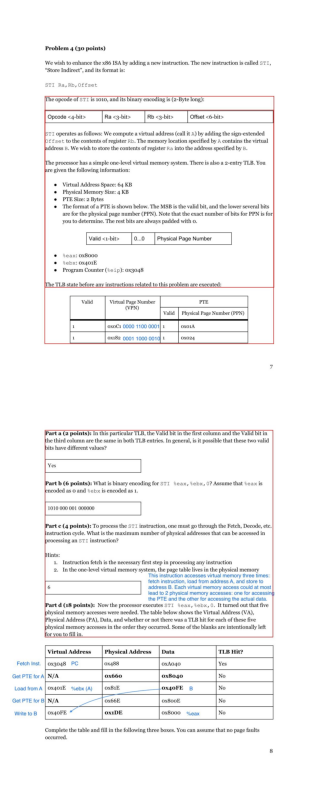

In [154]:
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt

def display_base64_image(base64_string):
    # Decode base64 string
    img_data = base64.b64decode(base64_string)

    # Create PIL Image object
    img = Image.open(io.BytesIO(img_data))

    # Display using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    return img

# Retrieve the first referenced document `retrieval_contents[0]
ret_result = client.agents.query.retrieval_info(message_id = query_result.message_id, agent_id=agent_id,content_ids=[query_result.retrieval_contents[0].content_id])
print("\nRetrieval Info:", ret_result)
base64_string = ret_result.content_metadatas[0].page_img
img = display_base64_image(base64_string)

## Step 5: Evaluate your Agent



Evaluation endpoints allow you to evaluate your Agent using a set of prompts (questions) and reference (gold) answers. We support two metrics: equivalence and groundedness.

Equivalance evaluates if the Agent response is equivalent to the ground truth (model-driven binary classification).  
Groundedness decomposes the Agent response into claims and then evaluates if the claims are grounded by the retrieved documents.

For those using unit tests, we also offer our `lmunit` endpoint, get more details [here](https://contextual.ai/blog/lmunit/)

Let's start with an evaluation dataset:

In [152]:
if not os.path.exists('data/CDA 4205 Computer Architecture Exam 2 Practice Solution-2.pdf'):
    print(f"Fetching data/CDA 4205 Computer Architecture Exam 2 Practice Solution-2.pdf")
    response = requests.get("data/CDA 4205 Computer Architecture Exam 2 Practice Solution-2.pdf")
    with open('data/CDA 4205 Computer Architecture Exam 2 Practice Solution-2.pdf', 'wb') as f:
        f.write(response.content)

In [153]:
eval = pd.read_pdf('data/CDA 4205 Computer Architecture Exam 2 Practice Solution-2.pdf')
eval.head()

AttributeError: module 'pandas' has no attribute 'read_pdf'

Start an evaluation job that measures both equivalence and groundedness

In [ ]:
with open('data/CDA 4205 Computer Architecture Exam 2 Practice Solution-2.pdf', 'rb') as f:
    eval_result = client.agents.evaluate.create(
        agent_id=agent_id,
        metrics=["equivalence", "groundedness"],
        evalset_file=f
    )

Evaluation jobs can take time, especially longer ones. Here is how you can check on their status. This dataset usually takes a few minutes to run.

In [ ]:
eval_status = client.agents.evaluate.jobs.metadata(agent_id=agent_id, job_id=eval_result.id)

from tqdm import tqdm

progress = tqdm(total=eval_status.job_metadata.num_predictions)
progress.update(eval_status.job_metadata.num_processed_predictions)
progress.set_description("Evaluation Progress")

Once the evaluation job is completed you can look at the final results across your evaluation dataset

In [ ]:
def process_binary_evaluation(binary_response):
    """
    Process BinaryAPIResponse into a pandas DataFrame.

    Args:
        binary_response: BinaryAPIResponse from evaluate.retrieve

    Returns:
        pd.DataFrame: Processed evaluation data
    """
    # Read the binary content
    content = binary_response.read()

    # Now decode the content
    lines = content.decode('utf-8').strip().split('\n')

    # Parse each line and flatten the results
    data = []
    for line in lines:
        data.append(json.loads(line))

    return pd.DataFrame(data)

In [ ]:
eval_results = client.agents.datasets.evaluate.retrieve(dataset_name=eval_status.dataset_name, agent_id = agent_id)
df = process_binary_evaluation(eval_results)
df.head()

Here I am going to save the results of the evaluation to a csv file.

In [ ]:
df.to_csv('eval_results_python.csv', index=False)

Next let's separate out the non-equivalent results so we can diagnose the issue:

In [ ]:
# Filter for results with equivalence score of 0.0
zero_score_results = df[df['results'].apply(
    lambda x: x.get('equivalence', {}).get('score') == 0.0
)]

zero_score_results.head()

## Step 6: Improving your Agent

Contexual AI give you multile methods for improving your overall agent performance. Two methods available via the API are modifying the system prompt or tuning the models. It's recommended you start with modifying the system prompt before using tuning. Please reach out to the account team for more best practices around tuning.

Let's go through both options:

### 6.1 Revising the system prompt


After initial testing, you may want to revise the system prompt. Here I have an updated prompt with additional information in the critical guidelines section.  

In [ ]:
system_prompt2 = '''
You are a language model assisting with the digitization of academic exam content. The input is an exam which has been parsed into Markdown text. The exam contains one or more problems from a Computer Architecture assessment. A problem may include any combination of the following:
A context paragraph and/or just a short statement. (For example, it might be as short as "Convert the number 42 to binary," or as long as "Recall that the crux of tracing-based GC algorithms such as Mark-and-sweep
and Mark-sweep-compact is to start from “root”
variables and then identify all the reachable
variables. In the following code snippet, suppose the program just finishes executing L7, which
variables are regarded as “root”? Name only those that point to variables on the heap.
L1: int *p3;
L2: int* foo(int n) {
L3: int i,
*p1;
L4: p1 = (int *) malloc(n * sizeof(int));
L5: for (i=0; i<n; i++)
L6: p1[i] = i;
L7: p3 = p1[2];
L8: return p1;
L9: }
L10: void bar() {
L11: int *p2 = foo(5);
L12: }


")


One or more sub-questions, or be a single standalone question
Context for sub-questions separate from the sub-question and separate from the original problem context
Multiple questions within a subquestion
Point value associations for the problem or subproblems, including extra credit points
Solutions, either typed or handwritten
Tables, diagrams, circuit schematics, or block diagrams
Your task is to identify and separate each exam problem into the listed components, including context, sub-questions, figures, and solutions. Ignore any point values for any problem, question, or sub-question. Format your response using the template below. If the particular exam question lacks any of the listed components, do not include them.


Format:
## Problem Number
Problem Context: <Fill in here>


Sub-question 1.
Sub-question context: <Fill in here>
Figure context: <Fill in here>
Question: <Fill in here>
Solution: <Fill in here>


Sub-question 2.
Sub-question context: <Fill in here>
Figure context: <Fill in here>
Question: <Fill in here>
Solution: <Fill in here>




# '''
# You are an AI assistant specialized in financial analysis and reporting. Your responses should be precise, accurate, and sourced exclusively from official financial documentation provided to you. Please follow these guidelines:

# Data Analysis & Response Quality:
# * Only use information explicitly stated in provided documentation (e.g., earnings releases, financial statements, investor presentations)
# * Present comparative analyses using structured formats with tables and bullet points where appropriate
# * Include specific period-over-period comparisons (quarter-over-quarter, year-over-year) when relevant
# * Maintain consistency in numerical presentations (e.g., consistent units, decimal places)
# * Flag any one-time items or special charges that impact comparability

# Technical Accuracy:
# * Use industry-standard financial terminology
# * Define specialized acronyms on first use
# * Never interchange distinct financial terms (e.g., revenue, profit, income, cash flow)
# * Always include units with numerical values
# * Pay attention to fiscal vs. calendar year distinctions
# * Present monetary values with appropriate scale (millions/billions)

# Response Format:
# * Begin with a high-level summary of key findings when analyzing data
# * Structure detailed analyses in clear, hierarchical formats
# * Use markdown for lists, tables, and emphasized text
# * Maintain a professional, analytical tone
# * Present quantitative data in consistent formats (e.g., basis points for ratios)

# Critical Guidelines:
# * Do not make forward-looking projections unless directly quoted from source materials
# * Do not answer any questions for 2024 or later
# * Avoid opinions, speculation, or assumptions
# * If information is unavailable or irrelevant, clearly state this without additional commentary
# * Answer questions directly, then stop
# * Do not reference source document names or file types in responses
# * Focus only on information that directly answers the query

# For any analysis, provide comprehensive insights using all relevant available information while maintaining strict adherence to these guidelines and focusing on delivering clear, actionable information.
# '''


Let's now update the agent. And verify that changes by checking the agent metadata.

In [ ]:
client.agents.update(agent_id=agent_id, system_prompt=system_prompt2)

agent_config = client.agents.metadata(agent_id=agent_id)
print (agent_config.system_prompt)

Now that you have updated the agent, go try running another evaluation job. You will see the performance has improved.

### 6.2 Tuning the Contextual System

To run a tune job, you need to specificy a training file and an optional test file. (If no test file is provided, the tuning job will hold out a portion of the training file as the test set.)

A tuning job requires fine tuning models and the expectation should be it will take a couple of hours to run.

After the tune job completes, the metadata associated with the tune job will include evaluation results and a model

#### 6.2.1 Tuning dataset:  

The file should be in JSON array format, where each element of the array is a JSON object represents a single training example. The four required fields are guideline, prompt, response, and knowledge.

- knowledge field should be an array of strings, each string representing a piece of knowledge that the model should use to generate the response.

- reference: The gold-standard answer to the prompt.

- guideline field should be guidelines for the expected response.

- prompt field should be a question or statement that the model should respond to.

In [ ]:
if not os.path.exists('data/fin_train.jsonl'):
    print(f"Fetching data/fin_train.jsonl")
    response = requests.get("https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/01-getting-started/data/fin_train.jsonl")
    with open('data/fin_train.jsonl', 'wb') as f:
        f.write(response.content)

Next let's take a look at that file:

In [ ]:
with open('data/fin_train.jsonl', 'r') as f:
    for i, line in enumerate(f):
        if i < 10:
            print(line.strip())

#### 6.2.2 Starting a tuning model job

In [ ]:
with open('data/fin_train.jsonl', 'rb') as f:
    tune_job = client.agents.tune.create(
    agent_id=agent_id,
    training_file=f
)

tune_job_id = tune_job.id
print(f"Tune job created: {tune_job_id}")

In [ ]:
print (agent_id)
print (tune_job_id)

#### 6.2.3 Checking the status.

 You can check the status of the job using the API. For detailed information, refer to the API documentation. When the tuning job is complete, the status will turn to completed. The response payload will also contain evaluation_results, such as scores for equivalence.

In [ ]:
tune_metadata = client.agents.tune.jobs.metadata(
    agent_id=agent_id,
    job_id=tune_job_id
)
print("Tuning job metadata:", tune_metadata)

When the tuning job is complete, the metadata would look like the following:
```
TuneJobMetadata(job_status='completed',
                evaluation_results=None,
                model_id='registry/tuned-model-101',
                id='e44661f0-bagb-4919-b0df-bada36a31',
                evaluation_metadata={'status': 'completed',
                                     'metrics': {'equivalence_score': {'score': 0.873}},
                                     'job_metadata': {'num_predictions': 200,
                                                      'num_failed_predictions': 0,
                                                      'num_successful_predictions': 200,
                                                      'num_processed_predictions': 0},
                                     'dataset_name': 'eval-results-101',
                                     'model_name': 'registry/tuned-model-101',
                                     'tune_job_id': 'e44661f0-bagb-4919-b0df-bada36a31'})
 ```

#### 6.2.4 Updating the agent
Once the tuned job is complete, you can deploy the tuned model via editing the agent through API. Note that currently a single fine-tuned model deployment is allowed per tenant. Please see the API doc for more information.

In [ ]:
client.agents.update(agent_id=agent_id, llm_model_id=tune_metadata.model_id)

print("Agent updated with tuned model")

## Next Steps

In this Notebook, we've created a RAG agent in the finance domain, evaluating the agent, and tuned it for better performance. You can learn more at [docs.contextual.ai](https://docs.contextual.ai/). Finally, reach out to your account team if you have further questions or issues.